In [1]:
#imports
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhure\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#load the files
csv_file_path1 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/all-data.csv"
csv_file_path2 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/RoBERTaWeaklyLabelling.csv"
try:
    df1 = pd.read_csv(csv_file_path1, encoding='utf-8')
except UnicodeDecodeError:
    df1 = pd.read_csv(csv_file_path1, encoding='latin1')
try:
    df2 = pd.read_csv(csv_file_path2, encoding='utf-8')
except UnicodeDecodeError:
    df2 = pd.read_csv(csv_file_path2, encoding='latin1')

In [3]:
#concatinating dataframes
if set(df1.columns) == set(df2.columns):
    df = pd.concat([df1, df2], ignore_index=True)
else:
    column_mapping = {'news': 'news', 'label': 'label'}
    df2 = df2.rename(columns=column_mapping)
    
    # Append df2 to df1
    df = pd.concat([df1, df2], ignore_index=True)

df

,label,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
77155,neutral,Decision needed on BoE's ECB stake after Brexi...
77156,negative,Breakingviews TV: X factor
77157,positive,BRIEF-MagneGas To Expand Green Arc Sales Force...
77158,neutral,Uber introduces new safety features as it figh...


In [4]:
#converting all the labels to lowercase
df['label'] = df['label'].apply(lambda x: x.lower())
unique_labels = df['label'].unique()
print(unique_labels)

['neutral' 'negative' 'positive']


In [5]:
#drop null values
df = df.dropna(subset=['news'])

In [6]:
sid = SentimentIntensityAnalyzer()

In [7]:
# Function to get sentiment polarity
def get_sentiment_polarity(text):
    scores = sid.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [8]:
#get the sentiment scores using predefined lexicons
df.loc[:, 'sentiment'] = df['news'].apply(get_sentiment_polarity)

In [9]:
# Compare sentiment with labels
correct_predictions = df[df['sentiment'] == df['label']]
accuracy = len(correct_predictions) / len(df) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 94.47%


In [10]:
correct_predictions = df[df['sentiment'] == df['label']]
accuracy = len(correct_predictions) / len(df) 
print(f"Accuracy: {accuracy}")

Accuracy: 0.9447144275487276


In [11]:
precision = precision_score(df['label'], df['sentiment'], average='weighted')
recall = recall_score(df['label'], df['sentiment'], average='weighted')
f1 = f1_score(df['label'], df['sentiment'], average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.944940537136157
Recall: 0.9447144275487276
F1 Score: 0.9447390176290894


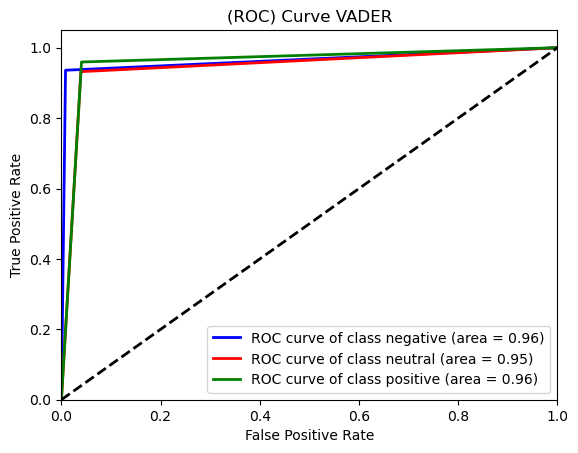

In [13]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
df.loc[:, 'label_encoded'] = label_encoder.fit_transform(df['label'])
df.loc[:, 'sentiment_encoded'] = label_encoder.transform(df['sentiment'])

# Binarize the labels for ROC
y_test = label_binarize(df['label_encoded'], classes=[0, 1, 2])
y_score = label_binarize(df['sentiment_encoded'], classes=[0, 1, 2])

n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve VADER')
plt.legend(loc="lower right")
plt.show()

The ROC curve for VADER is very close to the top-left corner of the plot. The AUC (Area Under the Curve) scores for all three classes (negative, neutral, and positive) are above 0.9, indicating excellent performance in distinguishing between sentiment classes.